<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Example-problem:-planar-arm" data-toc-modified-id="Example-problem:-planar-arm-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Example problem: planar arm</a></span><ul class="toc-item"><li><span><a href="#Our-model" data-toc-modified-id="Our-model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Our model</a></span></li><li><span><a href="#Example:-using-cma-es-to-reach-a-specific-point" data-toc-modified-id="Example:-using-cma-es-to-reach-a-specific-point-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Example: using cma-es to reach a specific point</a></span></li></ul></li><li><span><a href="#Quality-Diversity-with-MAP-Elites" data-toc-modified-id="Quality-Diversity-with-MAP-Elites-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Quality Diversity with MAP-Elites</a></span><ul class="toc-item"><li><span><a href="#Fitness-function" data-toc-modified-id="Fitness-function-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Fitness function</a></span></li><li><span><a href="#Archive-management" data-toc-modified-id="Archive-management-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Archive management</a></span></li><li><span><a href="#Random-initialization" data-toc-modified-id="Random-initialization-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Random initialization</a></span></li><li><span><a href="#Main-loop" data-toc-modified-id="Main-loop-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Main loop</a></span></li><li><span><a href="#Plot-progress" data-toc-modified-id="Plot-progress-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Plot progress</a></span></li><li><span><a href="#Plot-a-few-random-positions-from-the-map" data-toc-modified-id="Plot-a-few-random-positions-from-the-map-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Plot a few random positions from the map</a></span></li><li><span><a href="#Comparison-with-random-initialisation" data-toc-modified-id="Comparison-with-random-initialisation-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Comparison with random initialisation</a></span></li></ul></li><li><span><a href="#Directional-mutation-/-cross-over" data-toc-modified-id="Directional-mutation-/-cross-over-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Directional mutation / cross-over</a></span></li></ul></div>

# MAP-Elites



## Introduction



<center><img width="40%" src="figs/map_elites.svg"/></center>

<small>
<ul>
<li> Mouret JB. Evolving the behavior of machines: from micro to macroevolution. Iscience. 2020 Oct 28:101731. </li>
<li>Mouret JB, Clune J. Illuminating search spaces by mapping elites. arXiv preprint arXiv:1504.04909. 2015.</li>
<li>https://quality-diversity.github.io [most of the QD papers!]</li>
</ul>
</small>


## Example problem: planar arm

In industrial settings (Scara robot):
<center>
<img width="60%" src="figs/scara.jpg"/></td>
</center>

Image credit: Jamit (https://commons.wikimedia.org/wiki/File:SCara19.jpg)



### Our model
<center>
<img width="30%" src="figs/arm.svg"/>
</center>

- Genotype: $\alpha_0, \cdots, \alpha_k$
- Behavior: $(x,y)$

In [1]:
%matplotlib notebook
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import math
import random

In [2]:
def forward_kinematics(joint_positions, link_lengths):
    """
    Compute the forward kinematics of a planar robotic arm:
    given the joint positions and the link lengths, returns the 2D 
    Cartesian position of the end-effector (the hand)
    """
    assert(len(joint_positions) == len(link_lengths))
    
    # some init
    p = np.append(joint_positions, 0) # end-effector has no angle
    l = np.concatenate(([0], link_lengths)) # first link has no length
    joint_xy = np.zeros((len(p), 2)) # Cartesian positions of the joints
    mat = np.matrix(np.identity(4)) # 2D transformation matrix

    # compute the position of each joint
    for i in range(0, len(l)):
        m = [[math.cos(p[i]), -math.sin(p[i]), 0, l[i]],
             [math.sin(p[i]),  math.cos(p[i]), 0, 0],
             [0, 0, 1, 0],
             [0, 0, 0, 1]]
        mat = mat * np.matrix(m)
        v = mat * np.matrix([0, 0, 0, 1]).transpose()
        joint_xy[i,:] = np.array(v[0:2].A.flatten())
    return joint_xy # return the position of the joints

# example: 
print(forward_kinematics([0.1, 0.01, 0.5], [1]*3))

[[0.         0.        ]
 [0.99500417 0.09983342]
 [1.98896026 0.20961172]
 [2.80860828 0.78247918]]


<IPython.core.display.Javascript object>


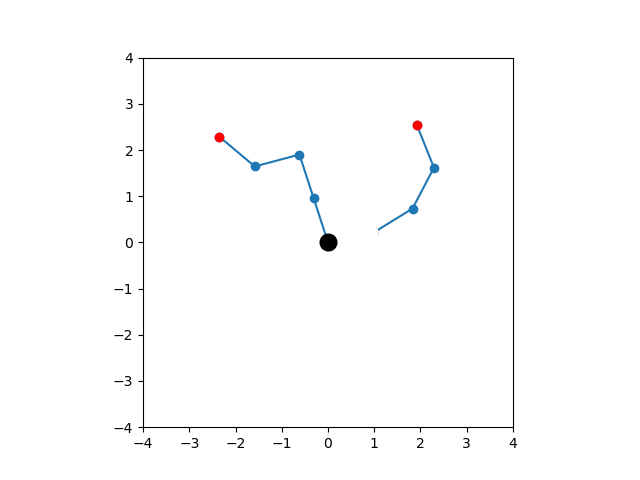

Output()

In [3]:
# Interactive plot of the arm configuration
num_dofs = 4
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.gca().set_aspect('equal', adjustable='box') # make the display a square
line = ax.plot([0]*num_dofs, [0]*num_dofs, 'o-')[0]# the arm
line2 = ax.plot([0], [0], 'o',color='red')[0] # end-effector
ax.plot([0],[0], 'o', markersize=12, color='black') # basis
ax.set_xlim([-num_dofs, num_dofs])
ax.set_ylim([-num_dofs, num_dofs])

# drawing procedure
def update(**data):
    p = np.array(list(data.values())) / 180.0 * math.pi;
    joints = forward_kinematics(p, np.ones(len(data)))
    line.set_xdata(joints[:,0])
    line.set_ydata(joints[:,1])
    line2.set_xdata(joints[-1,0])
    line2.set_ydata(joints[-1,1])
    print("x={} y={} std_dev={}".format(joints[-1,0], joints[-1,1], np.std(p)))
    
# widgets for interaction    
controls = []
names = {}
for i in range(0, num_dofs):
    slider = widgets.FloatSlider(value=np.random.uniform(0, 60),
                    description="joint " + str(i),min=0, max=360., step=1)
    controls += [slider]
    names[str(i)] = slider
    
uif = widgets.VBox(tuple(controls))
outf = widgets.interactive_output(update, names)
display(uif, outf)

### Example: using cma-es to reach a specific point

## Quality Diversity with MAP-Elites

### Fitness function

In [4]:
def fitness(genotype):
    # fitness is the standard deviation of joint angles (Smoothness)
    # (we want to minimize it)
    fit = 1 - np.std(genotype)

    # now compute the behavior
    #   scale to [0,2pi]
    g = np.interp(genotype, (0, 1), (0, 2 * math.pi))
    j = forward_kinematics(g, [1]*len(g))
    #  normalize behavior in [0,1]
    b = (j[-1,:]) / (2 * len(g)) + 0.5
    return fit, b# the fitness and the position of the last joint

print(fitness([0,0,0])) # should be [1, 0.5]
print(fitness([0.5,0,0])) # should be [, 0.5]

(1.0, array([1. , 0.5]))
(0.7642977396044841, array([0. , 0.5]))


### Archive management

In [5]:
# for simplicity, this is 2-Dimensional MAP-Elites
cols = 30
rows = 30
num_random = 100
num_dofs = 4

# we should use a dataclass, but this 3.9+
class Species:
    def __init__(self, genotype, behavior, fitness, niche=[]):
        self.genotype = genotype
        self.behavior = behavior
        self.fitness = fitness
        self.niche = niche
        
def add_to_archive(archive, species):
    n = species.behavior * np.array([rows, cols])
    x,y = min(round(n[0]), rows-1), min(round(n[1]), cols-1)
    if (not (x,y) in archive) or (archive[(x,y)].fitness < species.fitness):
        archive[(x,y)] = species
        species.niche = (x,y)



In [6]:

# compute the scores for the map : coverage and mean fitness
def qd_scores(archive):
    coverage = (len(archive)) / float(rows * cols)
    fit_list = [x.fitness for x in list(archive.values())]
    mean = sum(fit_list) / float(rows * cols)
    return coverage, mean

# useful function for later
def display_archive(archive):
    fit = np.zeros((rows, cols))
    m_min = 1e10
    m_max = 0
    for ((x,y), s) in archive.items():
        fit[x,y] = s.fitness
        if s.fitness < m_min:
            m_min = s.fitness
        if s.fitness > m_max:
            m_max = s.fitness
    plt.imshow(np.array(fit))
    plt.clim(m_min, m_max)

    fig.canvas.draw()
    return m_min, m_max


        

### Random initialization

In [7]:
def init_archive(num_random):# fill the archive with some random solutions
    # create an archive: a dictionnary indexed by coordinates
    archive = {}       
    for i in range(0, num_random):
        g = np.random.rand(num_dofs)
        f, b = fitness(g)
        add_to_archive(archive, Species(g, b, f))
    return archive


<IPython.core.display.Javascript object>


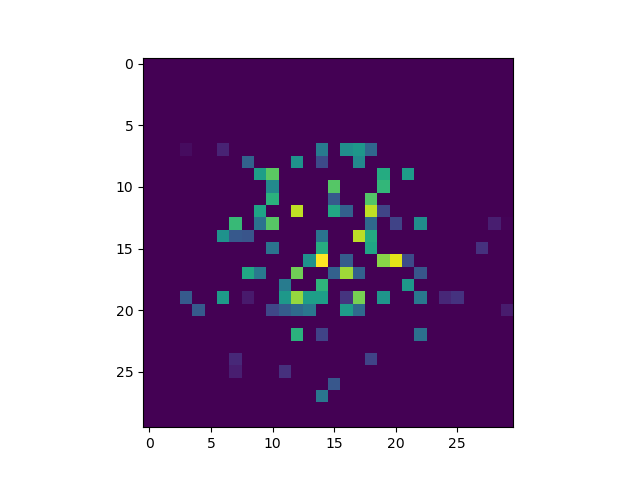

(0.6157801432188954, 0.940368752467931)

In [8]:
# some plotting
fig = plt.figure()
plt.gca().set_aspect('equal', adjustable='box') # make the display a square

archive = init_archive(num_random)
display_archive(archive)


<IPython.core.display.Javascript object>


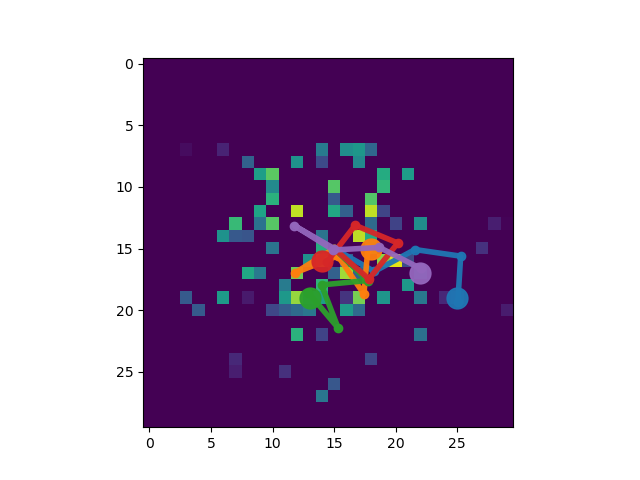

In [9]:
# plot the arm and the archive
fig = plt.figure()

def plot_arm(archive, k=5, c=None):
    display_archive(archive)
    for i in range(0, k):
        if c == None:
            x = random.choice(list(archive.values()))
        else:
            x = archive[c]
        angles = np.interp(x.genotype, (0, 1), (0, 2 * math.pi))
        j = forward_kinematics(angles, [1]*len(angles))
        b = j / (2 * len(angles)) + 0.5 # normalize for plotting

        p = plt.plot(b[:,1]*rows, b[:,0]*cols, 'o-', linewidth=4, alpha=0.95)
        plt.plot([x.niche[1]], [x.niche[0]], 'o', markersize=15, color=p[-1].get_color(), alpha=0.95)
    plt.show()

plot_arm(archive)

### Main loop

<IPython.core.display.Javascript object>


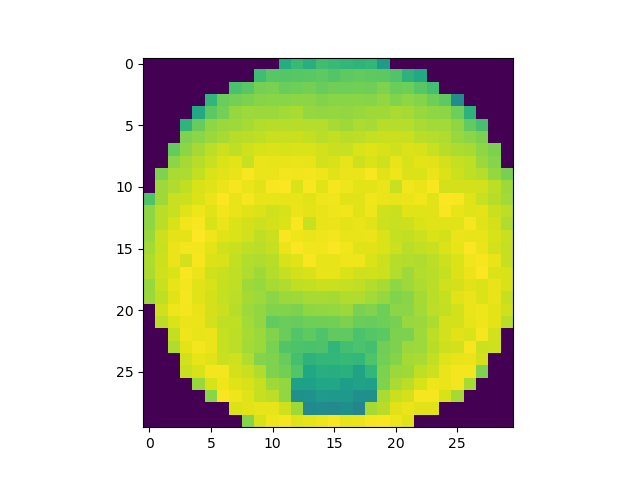

  0%|          | 0/50 [00:00<?, ?it/s]

In [10]:
from tqdm.notebook import tqdm # progress bar
fig = plt.figure()  

# now run the algorithm
num_iterations = 50
batch_size = 500
coverages = [] # for plotting progress
means = [] # for plotting mean

# random init
archive = init_archive(num_random)

# main loop
for j in tqdm(range(0, num_iterations)):
    display_archive(archive)
    for i in range(0, batch_size):
        # pick an existing random point in the archive
        x = random.choice(list(archive.values()))
        # mutate it (we can use more advanced variation techniques: NEAT, etc.)
        g = x.genotype + np.random.normal(0, 0.1, x.genotype.shape[0])
        # compute the fitness
        f, b = fitness(g)
        # add to archive
        add_to_archive(archive, Species(g, b, f))
    # save for plotting    
    coverage, mean = qd_scores(archive)
    coverages += [coverage]
    means += [mean]
    
archive_base = archive

### Plot progress

<IPython.core.display.Javascript object>


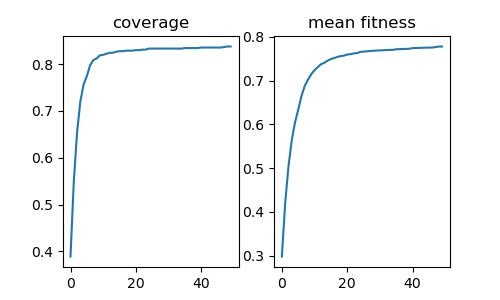

Text(0.5, 1.0, 'mean fitness')

In [11]:
fig = plt.figure(figsize=(5,3))
plt.subplot(1, 2, 1)
plt.plot(coverages)
plt.title("coverage")

plt.subplot(1,2, 2)
plt.plot(means)
plt.title("mean fitness")

### Plot a few random positions from the map

<IPython.core.display.Javascript object>


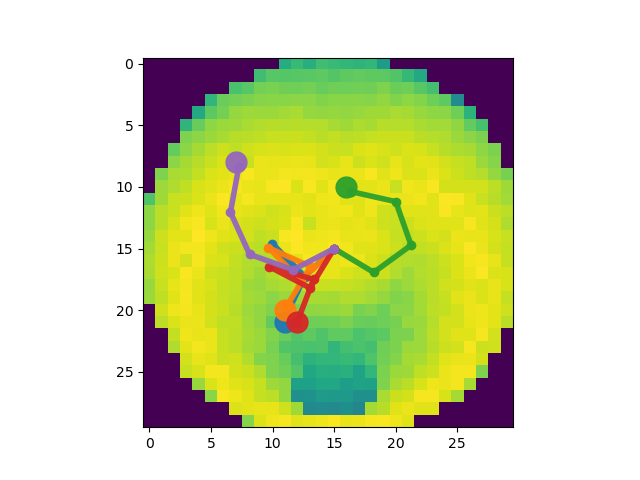

In [12]:
fig = plt.figure()
plot_arm(archive)

### Comparison with random initialisation

<IPython.core.display.Javascript object>


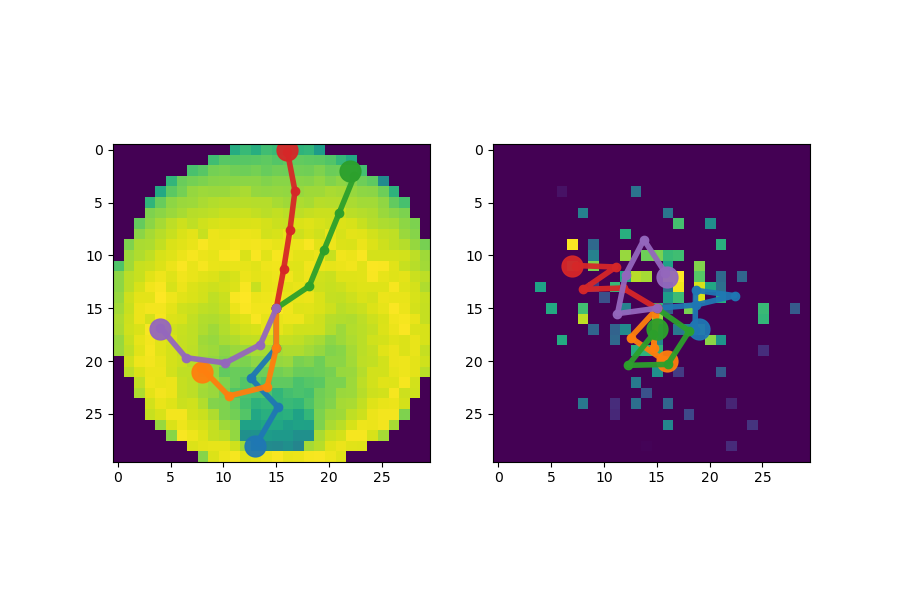

In [13]:
# comparison with random initialisation
# note the smoothness
fig = plt.figure(figsize=(9,6))
plt.subplot(1, 2, 1)
plot_arm(archive)

plt.subplot(1,2, 2)
archive2 = init_archive(num_random)
plot_arm(archive2)

<IPython.core.display.Javascript object>


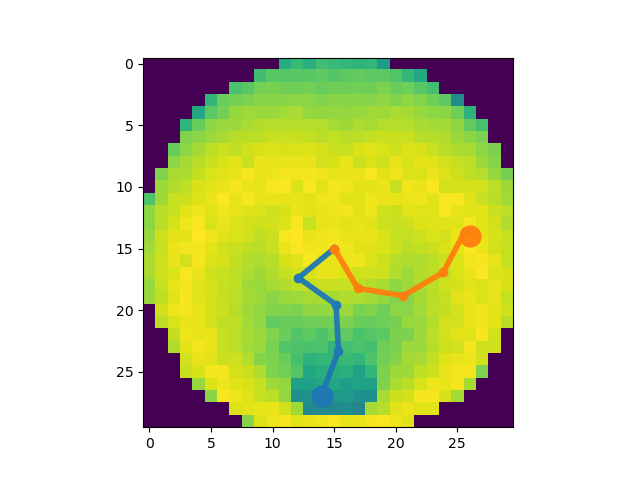

0.7419692636395389
0.978352994835867


In [14]:
# examples of bad and good fitness values
fig = plt.figure()
plot_arm(archive, 1, (27,14))
print(archive[(27,14)].fitness)
plot_arm(archive,1, (14,26))
print(archive[(14,26)].fitness)




## Directional mutation / cross-over

So far, we used a basic Gaussian mutation:

$$x^{(t+1)} = x^{(t)} + \sigma \mathcal{N}(0,I)$$
(with $\sigma = 0.1$).

But we can leverage the hypervolume and use an archive-based cross-over:

$$ x^{(t+1)} = x^{(t)} + \sigma_1 \mathcal{N}(0,1) \big(x^{(t)} - y^{(t)}\big) + \sigma_2 \mathcal{N}(0,I) $$

We use here $\sigma_1 = 0.1$ and $\sigma_2 = 0.025$ (the first part dominates)

<IPython.core.display.Javascript object>


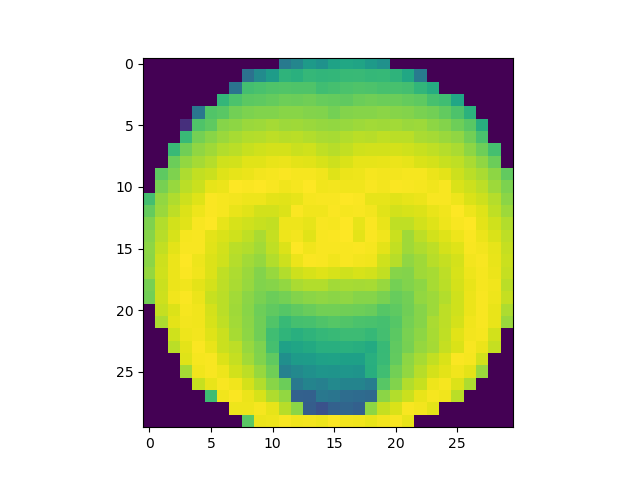

  0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
## Adding directionnal mutation / Cross-over
from tqdm.notebook import tqdm # progress bar
fig = plt.figure()  

# now run the algorithm
num_iterations = 50
batch_size = 500

# copy previous data for comparison
means_base = means
coverages_base = coverages
means = []
coverages = []

# random initialisation
archive = init_archive(num_random)

for j in tqdm(range(0, num_iterations)):
    display_archive(archive)
    for i in range(0, batch_size):
        # pick TWO points the archive
        x = random.choice(list(archive.values())).genotype
        y = random.choice(list(archive.values())).genotype
        # mutate it (we can use more advanced variation techniques: NEAT, etc.)
        # be careful: the first random.normal() is a 1-d normal
        g = x + (x - y) * np.random.normal(0, 0.1) + np.random.normal(0, 0.025, x.shape[0])
        # compute the fitness
        f, b = fitness(g)
        # add to archive
        add_to_archive(archive, Species(g, b, f))
    # save for plotting    
    coverage, mean = qd_scores(archive)
    coverages += [coverage]
    means += [mean]
        

<IPython.core.display.Javascript object>


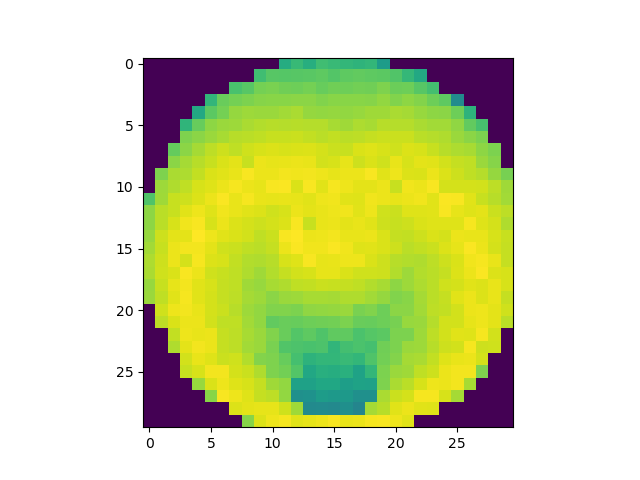

(0.42904721874088425, 0.9968935948692715)

In [16]:
fig = plt.figure()  


display_archive(archive_base)

<IPython.core.display.Javascript object>


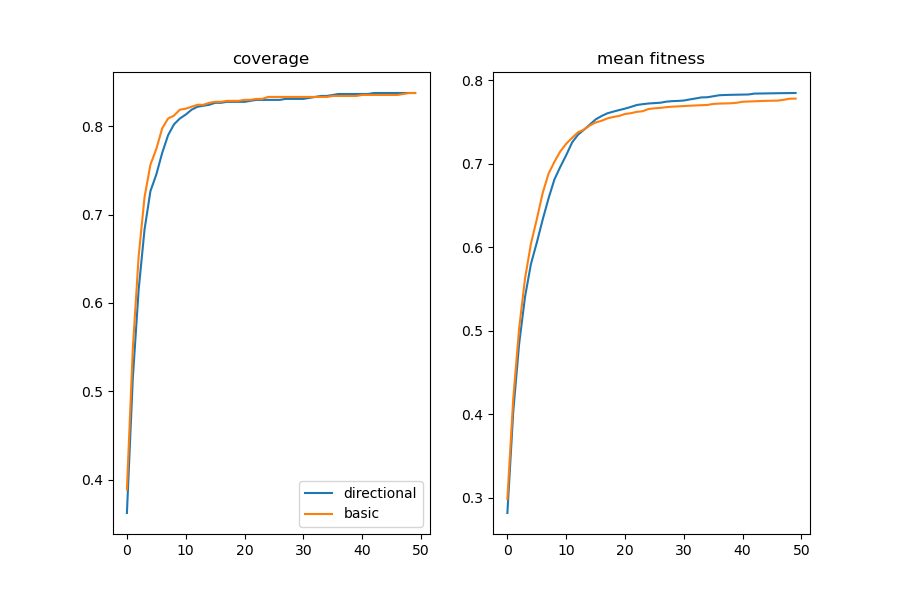

Text(0.5, 1.0, 'mean fitness')

In [17]:
fig = plt.figure(figsize=(9,6))
plt.subplot(1, 2, 1)
plt.plot(coverages, label='directional')
plt.plot(coverages_base, label='basic')
plt.title("coverage")
plt.legend()

plt.subplot(1,2, 2)
plt.plot(means, label="directional")
plt.plot(means_base, label="basic")
#plt.ylim([0.7, 0.8])

plt.title("mean fitness")

#difference is small, but this is a very simple problem!